Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading CSV files

In [2]:
calls=pd.read_csv(r"C:\Users\Dell\Downloads\callsf0d4f5a.csv")
customers=pd.read_csv(r"C:\Users\Dell\Downloads\customers2afd6ea.csv")
sentiment=pd.read_csv(r"C:\Users\Dell\Downloads\sentiment_statisticscc1e57a.csv")
reason=pd.read_csv(r"C:\Users\Dell\Downloads\reason18315ff.csv")

Merging into 1 dataset

In [3]:
df=pd.merge(calls,customers,on='customer_id',how='left')
df=pd.merge(df,sentiment,on='call_id',how='left')
df=pd.merge(df,reason,on='call_id',how='left')
df.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,neutral,angry,-0.04,0.39,Voluntary Cancel
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,calm,neutral,0.02,0.35,Booking
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,neutral,polite,-0.13,0.32,IRROPS
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,neutral,frustrated,-0.20,0.20,Upgrade
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,neutral,polite,-0.05,0.35,Seating


DataCleanup

In [4]:
df.dropna(subset=['agent_tone','average_sentiment'],inplace=True) 
df['elite_level_code'].fillna(-1,inplace=True)
df['primary_call_reason'].fillna('unknown',inplace=True)
df['call_start_datetime']=pd.to_datetime(df['call_start_datetime'],errors='coerce')
df['agent_assigned_datetime']=pd.to_datetime(df['agent_assigned_datetime'],errors='coerce')
df['call_end_datetime']=pd.to_datetime(df['call_end_datetime'],errors='coerce')
df.drop_duplicates(inplace=True)



In [5]:
mapping = {
    "Voluntary Cancel": ["Voluntary Cancel", "Voluntary  Cancel", "Voluntary   Cancel", "Voluntary Cancel  ", "Voluntary Cancel "],
    "Booking": ["Booking", "Booking  "],
    "IRROPS": ["IRROPS", "IRROPS  ", "IRROPS "],
    "Upgrade": ["Upgrade", "Upgrade  ", "Upgrade "],
    "Seating": ["Seating", "Seating  ", "Seating "],
    "Mileage Plus": ["Mileage Plus", "Mileage  Plus", "Mileage   Plus", "Mileage Plus  "],
    "Checkout": ["Checkout", "Checkout  "],
    "Unknown": ["Unknown", "unknown"],
    "Voluntary Change": ["Voluntary Change", "Voluntary  Change", "Voluntary Change  ", "Voluntary Change "],
    "Post Flight": ["Post Flight", "Post-Flight", "Post-Flight  ", "Post Flight  "],
    "Check In": ["Check In", "Check-In", "Check-In  ", "Check In  "],
    "Other Topics": ["Other Topics", "Other  Topics", "Other Topics  "],
    "Communications": ["Communications", "Communications  "],
    "Schedule Change": ["Schedule Change", "Schedule Change  "],
    "Products & Services": ["Products & Services", "Products and Services", "Products and Services  "],
    "Digital Support": ["Digital Support", "Digital   Support", "Digital  Support", "Digital Support  "],
    "Disability": ["Disability", "Disability  "],
    "Unaccompanied Minor": ["Unaccompanied Minor", "Unaccompanied Minor  "],
    "Baggage": ["Baggage", "Baggage  "],
    "Traveler Updates": ["Traveler Updates", "Traveler  Updates", "Traveler Updates  "],
    "ETC": ["ETC", "ETC  "],
}
def normalize_input(input_string):
    # Clean up input (e.g., strip leading/trailing spaces)
    cleaned_input = input_string.strip()

    # Iterate through the mapping to find a match
    for key, variations in mapping.items():
        if cleaned_input in variations:
            return key  # Return the standard key if a match is found

    return "Unknown"  # If no match is found, return "Unknown"

# Apply the normalization function to the "primary_call_reason" column
df['primary_call_reason'] = df['primary_call_reason'].apply(normalize_input)

General Feature Engineering

In [6]:
df['call_duration'] = (df['call_end_datetime'] - df['call_start_datetime']).dt.total_seconds()
df['handle_time'] = (df['call_end_datetime'] - df['agent_assigned_datetime']).dt.total_seconds() 
df['wait_time'] = (df['agent_assigned_datetime'] - df['call_start_datetime']).dt.total_seconds() 
df['hour_of_day'] = df['call_start_datetime'].dt.hour
df['day_of_week'] = df['call_start_datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_month'] = df['call_start_datetime'].dt.day
df['month'] = df['call_start_datetime'].dt.month

df['silence_time'] = (df['silence_percent_average'] / 100) * df['call_duration']
df['transcript_word_count']=df['call_transcript'].apply(lambda x : len(str(x).split()) if pd.notnull(x) else 0)

df.drop(columns=['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71593 entries, 0 to 71809
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  71593 non-null  int64  
 1   customer_id              71593 non-null  int64  
 2   agent_id                 71593 non-null  int64  
 3   call_transcript          71593 non-null  object 
 4   customer_name            71593 non-null  object 
 5   elite_level_code         71593 non-null  float64
 6   agent_tone               71593 non-null  object 
 7   customer_tone            71593 non-null  object 
 8   average_sentiment        71593 non-null  float64
 9   silence_percent_average  71593 non-null  float64
 10  primary_call_reason      71593 non-null  object 
 11  call_duration            71593 non-null  float64
 12  handle_time              71593 non-null  float64
 13  wait_time                71593 non-null  float64
 14  hour_of_day           

In [7]:
df.nunique()

call_id                    71593
customer_id                71593
agent_id                     383
call_transcript            71593
customer_name              54388
elite_level_code               7
agent_tone                     5
customer_tone                  5
average_sentiment            167
silence_percent_average       99
primary_call_reason           21
call_duration                127
handle_time                  119
wait_time                     13
hour_of_day                   24
day_of_week                    7
day_of_month                  31
month                          2
silence_time                3013
transcript_word_count        618
dtype: int64

array([[<AxesSubplot:title={'center':'handle_time'}>,
        <AxesSubplot:title={'center':'wait_time'}>]], dtype=object)

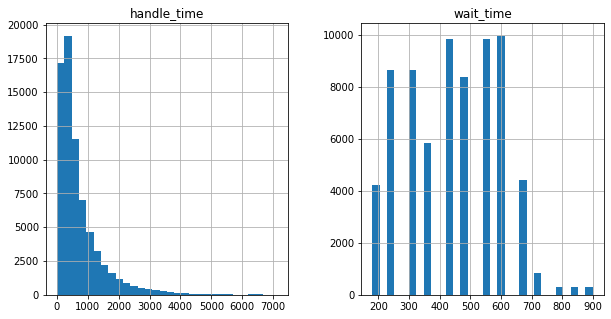

In [8]:
df[['handle_time','wait_time']].hist(bins=30,figsize=(10,5))

This shows distrubutions of handle and wait times , wait times are more evenly distributed

Correlation Analysis

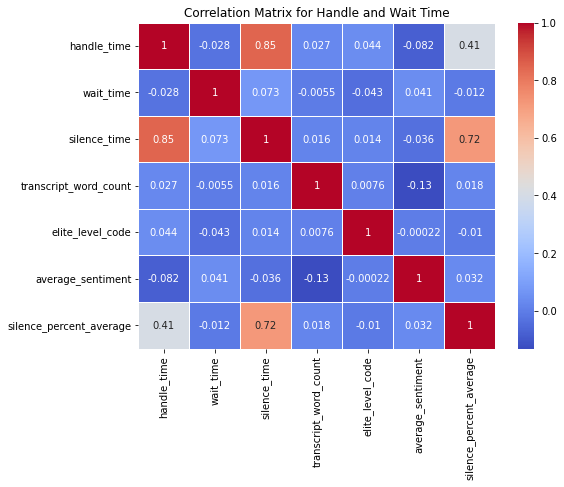

In [20]:
corr_matrix = df[['handle_time', 'wait_time', 'silence_time', 'transcript_word_count', 'elite_level_code','average_sentiment','silence_percent_average']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Handle and Wait Time')
plt.show()

correlation between numeric parameters is minimal except in case of silence time and handle time where it is significant

primary_call_reason
Checkout               6.000450
Post Flight            5.180641
ETC                    5.165577
Mileage Plus           4.404176
Voluntary Cancel       4.282319
IRROPS                 4.276025
Voluntary Change       3.942592
Unknown                3.811445
Communications         3.735874
Products & Services    3.565710
Traveler Updates       3.540721
Unaccompanied Minor    3.517269
Seating                3.162841
Upgrade                3.064233
Check In               3.027934
Digital Support        2.907600
Baggage                2.626936
Schedule Change        2.542060
Booking                2.201742
Disability             2.129731
Other Topics           2.029875
Name: silence_time, dtype: float64


<AxesSubplot:title={'center':'Top 10 Call Reasons with Highest Silence Time'}, ylabel='primary_call_reason'>

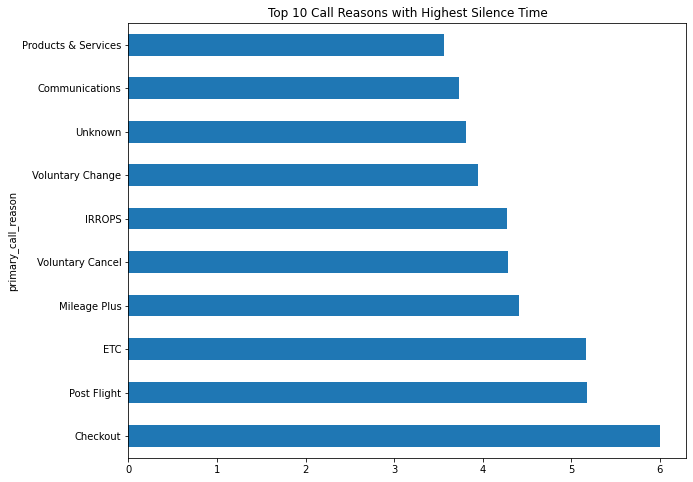

In [22]:
silence_by_reason = df.groupby('primary_call_reason')['silence_time'].mean().sort_values(ascending=False)
print(silence_by_reason)
silence_by_reason.head(10).plot(kind='barh', figsize=(10, 8), title='Top 10 Call Reasons with Highest Silence Time')

determing common reasons for high silence time  with related to high handle time, to get most common reasons improvements here will dramatically improve AHT

<AxesSubplot:title={'center':'Silence Time by Customer Tone'}, xlabel='customer_tone'>

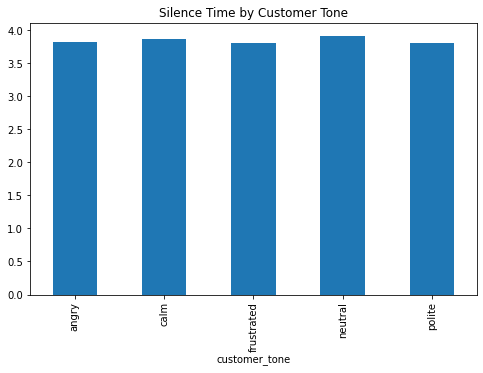

In [11]:
silence_by_tone = df.groupby('customer_tone')['silence_time'].mean()
silence_by_tone.plot(kind='bar', figsize=(8, 5), title='Silence Time by Customer Tone')

Tone has little significance in AHT

<AxesSubplot:title={'center':'Top 10 Agents by Average Silence Time'}, ylabel='agent_id'>

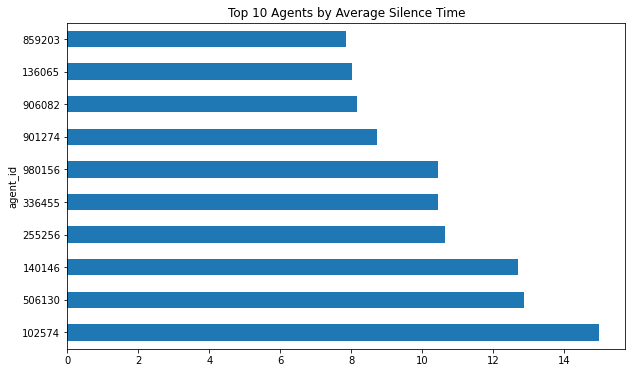

In [12]:
agent_silence = df.groupby('agent_id')['silence_time'].mean().sort_values(ascending=False)
agent_silence.head(10).plot(kind='barh', figsize=(10, 6), title='Top 10 Agents by Average Silence Time')

CategoricalFactor Analysis

<AxesSubplot:title={'center':'Top 10 Call Reasons with Highest handle Time'}, ylabel='primary_call_reason'>

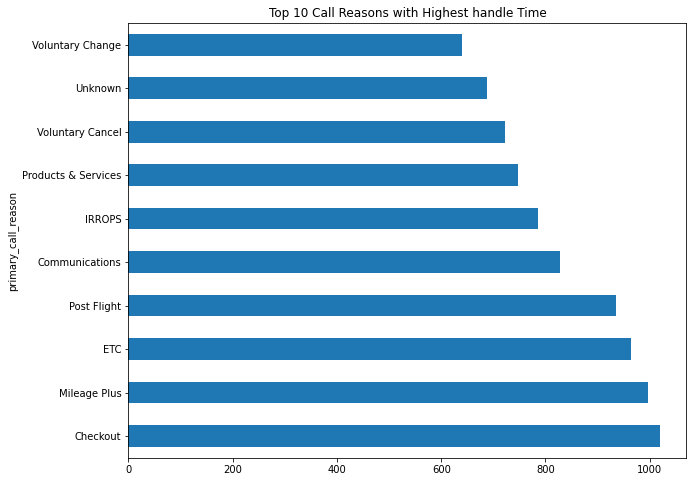

In [13]:
handle_by_reason = df.groupby('primary_call_reason')['handle_time'].mean().sort_values(ascending=False)
handle_by_reason.head(10).plot(kind='barh', figsize=(10, 8), title='Top 10 Call Reasons with Highest handle Time')

                  handle_time   wait_time
elite_level_code                         
-1.0               669.315421  442.626168
 0.0               697.203851  438.522394
 1.0               689.093953  436.911488
 2.0               727.891581  432.875343
 3.0               728.970100  429.494667
 4.0               788.615819  413.389831
 5.0               898.966260  411.083991


<AxesSubplot:title={'center':'Handle and Wait Time by Loyalty Level'}, xlabel='elite_level_code'>

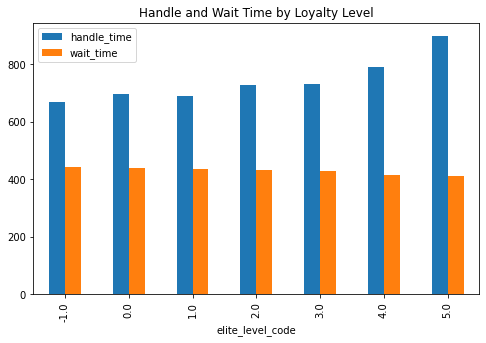

In [14]:
loyalty_analysis = df.groupby('elite_level_code')[['handle_time', 'wait_time']].mean()
print(loyalty_analysis)
loyalty_analysis.plot(kind='bar', figsize=(8, 5), title='Handle and Wait Time by Loyalty Level')

wait time are not affeted by loyality (expected depend on system load), handle time increase with loyality for example high loyality more complex issues

               handle_time   wait_time
customer_tone                         
angry           696.679891  436.462727
calm            700.609705  437.825479
frustrated      693.767167  436.733573
neutral         708.701326  437.799681
polite          691.064394  436.372398


<AxesSubplot:title={'center':'Handle and Wait Time by Customer Tone'}, xlabel='customer_tone'>

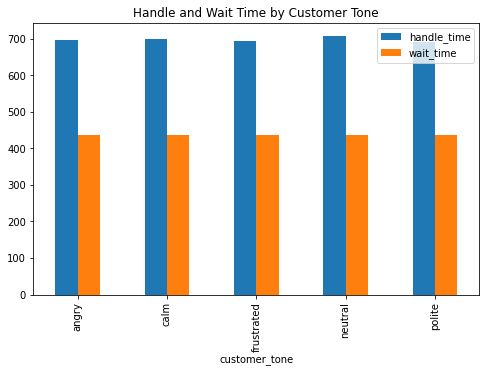

In [15]:
tone_analysis = df.groupby('customer_tone')[['handle_time', 'wait_time']].mean()
print(tone_analysis)
tone_analysis.plot(kind='bar', figsize=(8, 5), title='Handle and Wait Time by Customer Tone')

same as silent time tone has no effect on AHT or AST

<AxesSubplot:title={'center':'Average Handle and Wait Time by Hour of Day'}, xlabel='hour_of_day'>

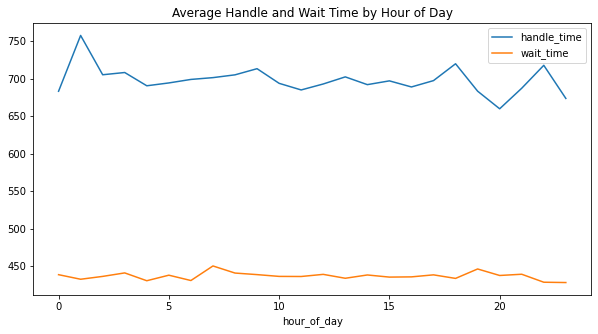

In [16]:
time_analysis_hour = df.groupby('hour_of_day')[['handle_time', 'wait_time']].mean()
time_analysis_hour.plot(kind='line', figsize=(10, 5), title='Average Handle and Wait Time by Hour of Day')

AST is mostly consistent throughout the day but AHT fluctuated between 7 pm and 1 am

<AxesSubplot:title={'center':'Average Handle and Wait Time by Day of Week'}, xlabel='day_of_week'>

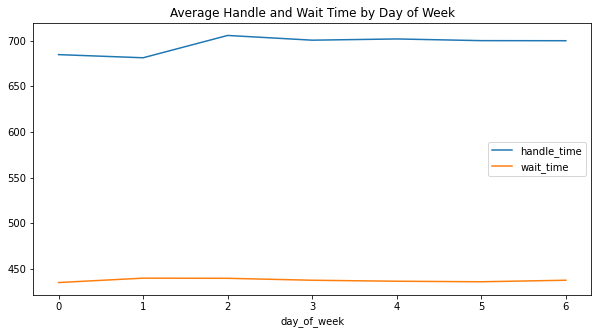

In [17]:
time_analysis_week = df.groupby('day_of_week')[['handle_time', 'wait_time']].mean()
time_analysis_week.plot(kind='line', figsize=(10, 5), title='Average Handle and Wait Time by Day of Week')

AST is consistent throughout the week but AHT is a bit less on sund

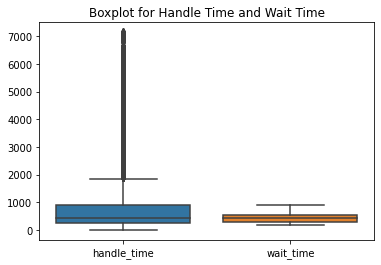

In [18]:
sns.boxplot(data=df[['handle_time', 'wait_time']])
plt.title('Boxplot for Handle Time and Wait Time')
plt.show()

handle time has some outliers that pull the average up investigation on these outliers is needed